# 프로젝트 : 인물 모드 문제점 찾기

### Step 1. 셸로우 포커스 만들기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image1.JPG' 
img_orig1 = cv2.imread(img_path1)
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.JPG'
img_orig2 = cv2.imread(img_path2)
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.JPG'
img_orig3 = cv2.imread(img_path3)
print(img_orig1.shape,img_orig2.shape,img_orig3.shape)

(2448, 3264, 3) (1125, 1125, 3) (3024, 3024, 3)


### DeepLapModel 만들기

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 구글에서 파일 다운로드

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj12/aiffel/human_segmentation/models
model loaded successfully!


#### img resize

In [5]:
img_resized, seg_map = MODEL.run(img_orig1)
img_resized2, seg_map2 = MODEL.run(img_orig2)
img_resized4, seg_map4 = MODEL.run(img_orig3)
print (img_orig1.shape, img_resized.shape, seg_map.max())
print (img_orig2.shape, img_resized2.shape, seg_map2.max())
print (img_orig3.shape, img_resized4.shape, seg_map4.max())

(2448, 3264, 3) (384, 513, 3) 15
(1125, 1125, 3) (513, 513, 3) 12
(3024, 3024, 3) (513, 513, 3) 15


#### DeepLab라벨종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 세그멘테이션 결과 보기

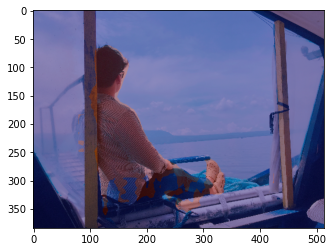

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


#### 세그멘테이션 결과 원래 크기로 복원

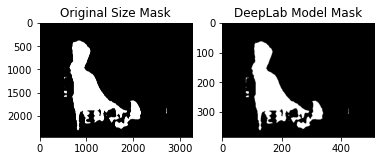

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 배경 흐리게 하기 

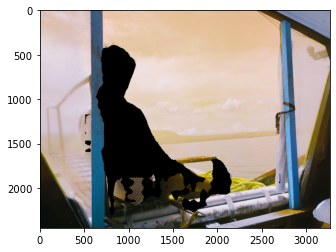

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig1, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#### 이미지 블러 처리

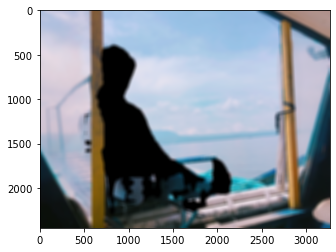

In [10]:
img_bg_blur = cv2.blur(img_bg, (50,50))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린배경과 원본 합성 & 원본 비교

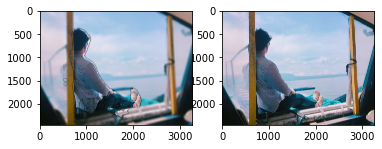

In [11]:
ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,1)
img_concat = np.where(img_mask_color==255, img_orig1, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


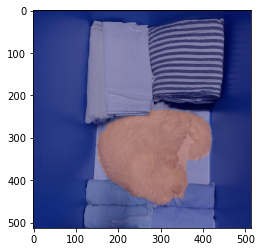

In [12]:
img_show = img_resized2.copy()
seg_map = np.where(seg_map2 == 12, 12, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션 결과 원래 크기로 복원

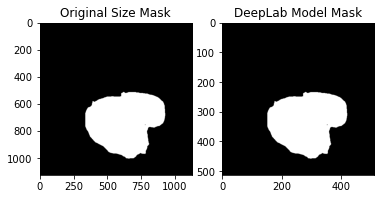

In [13]:
img_mask_up = cv2.resize(img_mask, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 배경 흐리게 하기 

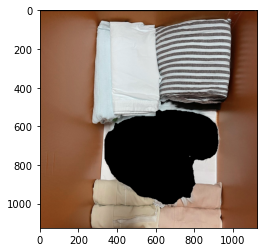

In [14]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig2, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#### 이미지 블러 처리

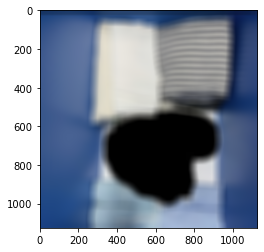

In [15]:
img_bg_blur = cv2.blur(img_bg, (50,50))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린배경과 원본 합성 & 원본 비교

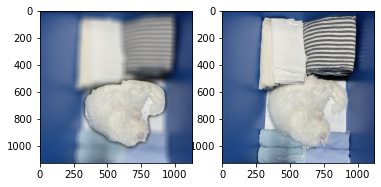

In [16]:
ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,1)
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


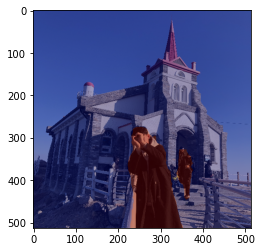

In [17]:
img_show = img_resized4.copy()
seg_map = np.where(seg_map4 == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 세그멘테이션 결과 원래 크기로 복원

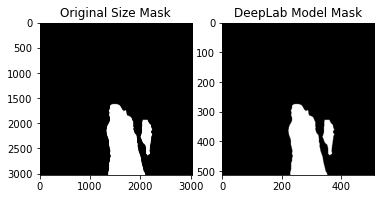

In [18]:
img_mask_up = cv2.resize(img_mask, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 배경 흐리게 하기 

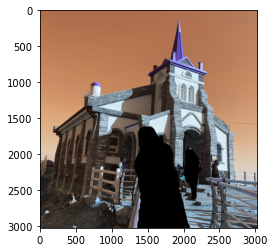

In [19]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig3, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#### 이미지 블러 처리

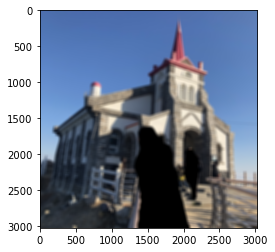

In [20]:
img_bg_blur = cv2.blur(img_bg, (50,50))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐린배경과 원본 합성 & 원본 비교

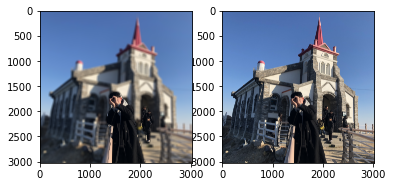

In [21]:
ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,1)
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


### Step2. 배경전환 크로마키 사진

In [22]:
image_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.JPG' 
image_orig = cv2.imread(image_path)
call_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/call.jpeg' 
call_img_orig = cv2.imread(call_path)

print(image_orig.shape,call_img_orig.shape)

(3024, 3024, 3) (512, 512, 3)


In [23]:
image_img_resized, image_seg_map = MODEL.run(image_orig)
call_img_resized = cv2.resize(call_img_orig, (3024, 3024))

print (image_orig.shape, image_img_resized.shape, image_seg_map.max(),image_orig.shape, image_img_resized.shape)

(3024, 3024, 3) (513, 513, 3) 15 (3024, 3024, 3) (513, 513, 3)


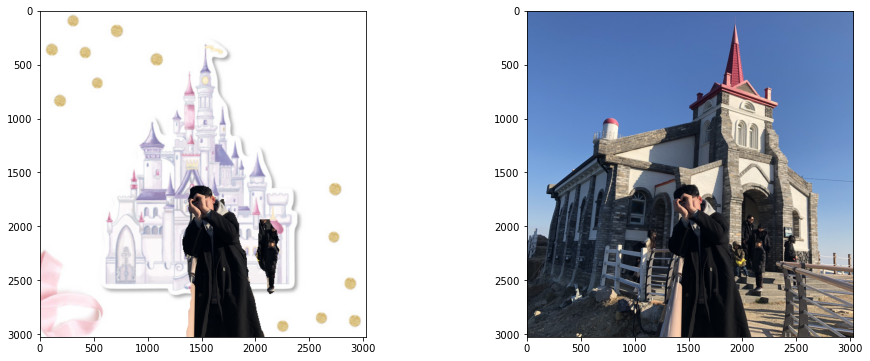

In [24]:
# 세그멘테이션
image_img_show = image_img_resized.copy()
image_seg_map = np.where(image_seg_map == 15, 15, 0) 
image_img_mask = image_seg_map * (255/image_seg_map.max()) 
image_img_mask = image_img_mask.astype(np.uint8)
image_color_mask = cv2.applyColorMap(image_img_mask, cv2.COLORMAP_JET)
image_img_show = cv2.addWeighted(image_img_show, 0.6, image_color_mask, 0.35, 0.0)

# 마스크업
image_img_mask_up = cv2.resize(image_img_mask, image_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 배경 제거
image_img_mask_color = cv2.cvtColor(image_img_mask_up, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(16, 6))

# 이미지합성과 원본 비교
ax = plt.subplot(1,2,1)
image_img_concat = np.where(image_img_mask_color==255, image_orig, call_img_resized)
plt.imshow(cv2.cvtColor(image_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))

plt.show()

### Step 3. 사진 문제점 

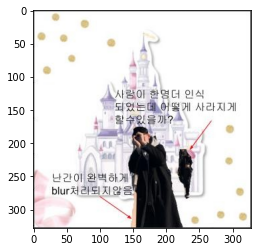

In [25]:
image_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/revised.jpg' 
image_orig = cv2.imread(image_path)

ax = plt.subplot()
plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))

plt.show()

### Step 4. 해결 방법 제안

### Monodepth2 중요하지 않는 픽셀에 대한 초점을 제거 하는 자동 마스킹 기술에 대해 좀더 자세히 공부해서 한번 시도해봐야겠다. 

### 프로젝트를 마치며...

### 크게 어려운 부분은 없었던거 같다 이번 익스플로레이션의 핵심은 Step4 의 해결 방법 제안 인거같은데... 아직 모델들을 정확하게 파악하지 못하는 나의 능력이 한탄스러울뿐이다... 앞으로 가야할길이 먼 같다 세그멘테이션 개념과 실습을 통해서 문제점 파악은 충분히 이해 했다. 